<a href="https://colab.research.google.com/github/YonDraco/learn-deep-learning/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_Transfer_Learning_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Speaker: Ba Ngoc - Founder @ProtonX @VietAI Hanoi

- Bài tập phân loại ảnh sử dụng Transfer Learning - Bài tập có 4 phần cần hoàn thành

In [15]:
#@title 1. Tải dữ liệu
train_folder = './data/cats_and_dogs_filtered/train'
valid_folder = './data/cats_and_dogs_filtered/validation'

!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O ./cats_and_dogs_filtered.zip

# Giải nén dữ liệu
main_folder = './data'
!unzip -q cats_and_dogs_filtered.zip -d $main_folder

--2021-04-10 07:50:17--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.15.80, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   286MB/s    in 0.2s    

2021-04-10 07:50:17 (286 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]

replace ./data/cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [16]:
# Sử dụng colab để review ảnh

In [17]:
#@title 2. Tải Pretrained model - Inception V3

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-04-10 07:56:07--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.12.240, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

./inception_v3_weig 100%[===================>]  83.84M   272MB/s    in 0.3s    

2021-04-10 07:56:07 (272 MB/s) - ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [31]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model


# 1. Sử dụng kiến trúc của mô hình
from tensorflow.keras.applications.inception_v3 import InceptionV3

# 2. Khởi tạo mô hình
pre_trained_model = InceptionV3(input_shape=(150,150,3), include_top=False, weights=None)  #### TODO 1: Sử dụng mô hình InceptionV3

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# 3. Load tham số đã được train vào mô hình
pre_trained_model.load_weights(local_weights_file)

In [32]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [33]:
# 4. Đóng băng (freeze) các lớp, trường hợp này chỉ sử dụng các tham số này 
# để inference (dự đoán) mà không sử dụng để training 

# 5. Câu hỏi (Có thể sử dụng các tham số này để tiếp tục huấn luyên không - Câu trả lời: Có)
for layer in pre_trained_model.layers:
  #### TODO 2: Cài đặt đóng băng các layer
 
    layer.trainable = False

In [34]:
# 6. Lấy layer ta muốn gắn thêm lớp phân loại theo bài toán của mình

#### TODO 3: Sử dụng lại mô hình đến layer mixed7

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [35]:
last_output

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

# 5. Xây dựng mô hình

In [37]:
from tensorflow.keras.optimizers import RMSprop

# 7. Duỗi features map thu được và đựa vào mạng nơ ron để phân loại
x = layers.Flatten()(last_output)
# 8. Thêm một lớp Dense
x = layers.Dense(1024, activation='relu')(x)
# 9. Thêm một lớp Dropout để cải thiện tính tổng quát của mô hình - tránh overfiting
x = layers.Dropout(0.2)(x)                  
# 10. Sử dụng activation sigmoid để phân loại 2 lớp
x = layers.Dense(1, activation='sigmoid')(x)           

# 11. Gắn mô hình phân loại của chúng ta vào pre trained model
model = Model( pre_trained_model.input, x) 

# 12. Bổ sung thuật toán trainining. RMSProp có khả năng điều chỉnh tốc độc học dựa vào độ lớn của đạo hàm

#### TODO 4: Compile thuật toán
model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])             

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

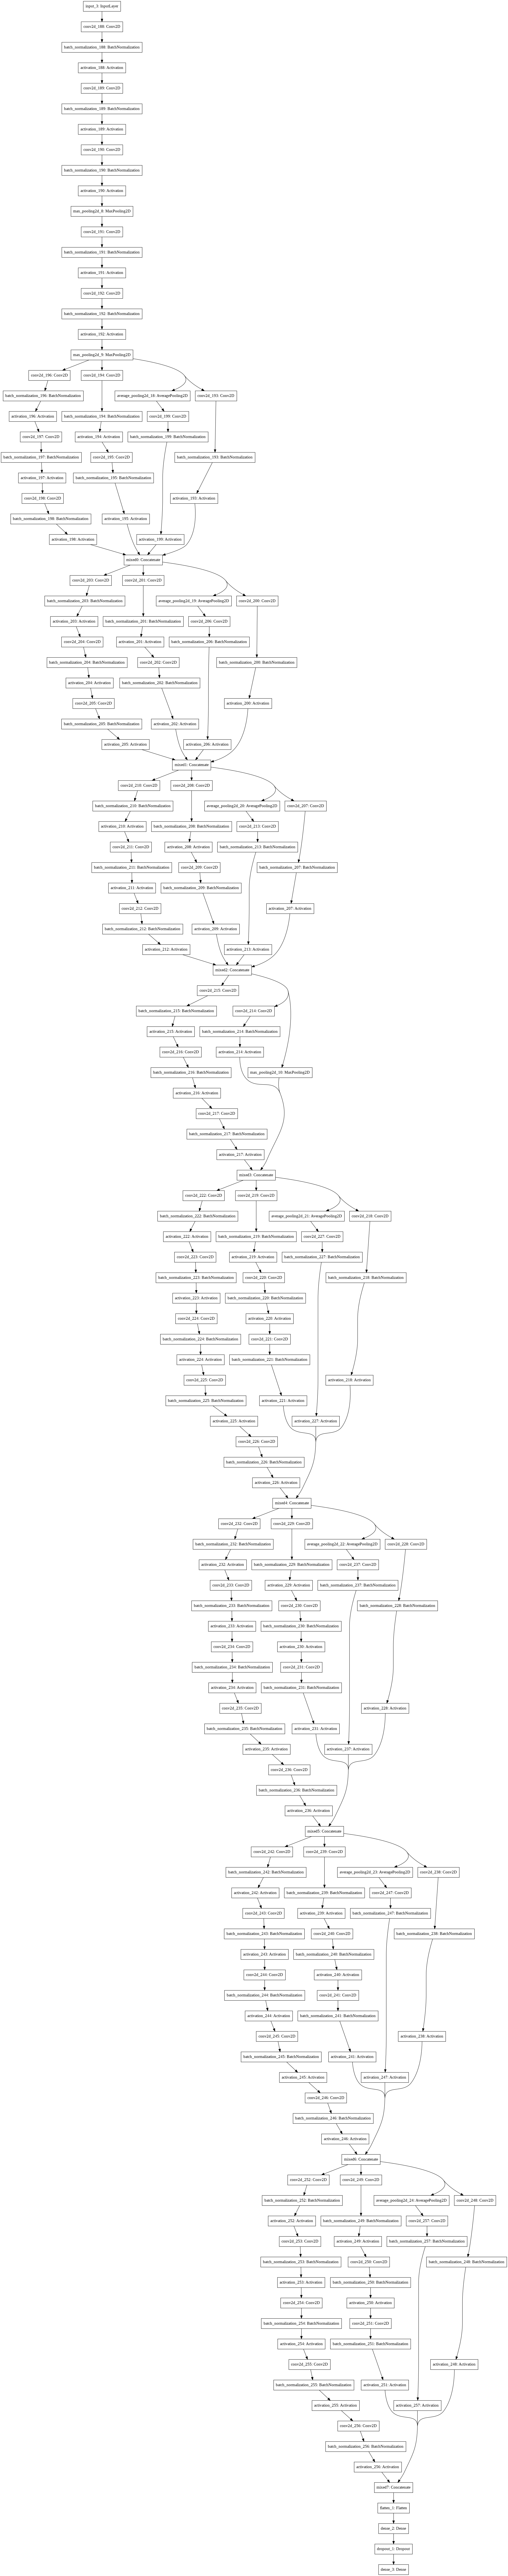

In [39]:
#@title Hiển thị mô hình
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [40]:
#@title Tăng cường data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 13. Bổ sung tăng cường data cho tập train
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# 13. Không bổ sung tăng cường data cho tập validation
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

# 14. Tiến hành load ảnh từ thư mục với tập train
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# 15. Tiến hành load ảnh từ thư mục với tập validation
validation_generator =  validation_datagen.flow_from_directory( valid_folder,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [41]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [42]:
# 16. Tiến hành training 
#### TODO 5: Tiến hành training
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100, # trong 1 epoch: chia thanh 100 lan chay nho hon
    epochs = 3, # so lan lap qua toan bo tap du lieu
    validation_steps = 50,
    verbose = 2 # Cach in kq training
)


Epoch 1/3
100/100 - 55s - loss: 0.3373 - acc: 0.8610 - val_loss: 0.1049 - val_acc: 0.9560
Epoch 2/3
100/100 - 19s - loss: 0.2413 - acc: 0.9105 - val_loss: 0.0851 - val_acc: 0.9650
Epoch 3/3
100/100 - 19s - loss: 0.2047 - acc: 0.9210 - val_loss: 0.0890 - val_acc: 0.9670


# 6. Tải ảnh của bạn và tiến hành dự đoán

Saving 2.jfif to 2.jfif
User uploaded file "2.jfif" with length 5143 bytes
[[0.99156344]]
Dog with output: [0.99156344]


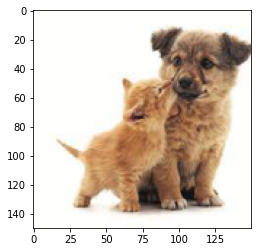

In [46]:
#@title Tải ảnh
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  image = plt.imread(fn)
  plt.imshow(image)
  

  image = Image.open(fn)
  # img = Image.fromarray(arr)
  image = image.resize(size=(150, 150))

  plt.imshow(image)
  data = np.asarray(image)
  data=np.expand_dims(data, 0)
  x = data / 255.0
  fi = model.predict(x)
  print(fi)
  print('Dog with output: {}'.format(fi[0])) if fi >= 0.5 else print('Cat with output: {}'.format(fi[0]))

In [48]:
model.save('dogandcat.h5')